In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.optimize import minimize
from statsmodels.tsa.arima.model import ARIMA
import meanreversion as mr

# Mean reversion metric

Mean reversion is a financial theory suggesting that asset prices and historical returns eventually revert to the long-term mean or average level of the entire dataset. This concept implies that high and low prices are temporary and that an asset's price will tend to move to the average price over time.

The goal of this project is to implement a **metric** that quantifies the degree of mean reversion of a given financial dataset. 

### Classifying the behaviour of the dataset:

Based on the temporal trend of a financial dataset, we can identify different characteristic behaviours:
1) **Trending**. A trending temporal series has a general direction in which the data points are moving over a period of time (usually a linear one). Trends are crucial for understanding the overall movement of asset prices and making informed investment decisions
2) **Stationary** (mean reverting). A process is said to be _stationary_ in a given time window if it oscillates around a fixed constant value and do not displays an evident growing trend. We can further distinguish two different extreme scenarios:
    - Mainly **random fluctuations**: the time series is stationary and its fluctuations around the average are merely stochastic short-period noisy perturbation
    - Statistically significative **oscillatory trend**: the process is still stationary but it displays an oscillatory trend that is not simply due to the random fluctuations



<p align="center">
    <img src="images/MR.png" width="600"/>
</p>




## The algorithm

1) We first verify whether the dataset has a _clear growing or decreasing trend_ (case [1]), in which case the dataset for sure isn't mean-reverting. It could still be possible that, when substracting the global trend of the time series, what we have left is a mean-reverting process, but we haven't worked on that.
To assess the _trendness_ of a dataset, we built a function `find_trend_mean(dataset)` that performs a linear fit on the experimental points and computes the statistical fit accuracy ($R^2$). If the confidence level is high and the slope of the fit is greater (in absolute value) than a fixed threshold, thenwe can conclude that a linear trend exists and label the dataset as a non mean-reverting

2) If the dataset is stationary, we can determine whether the oscillations around the average are purely stochastic or follow a more robust oscillatory trend. We define a metric $\eta$ such that $0 < \eta < 1$ if the dataset in a given time window $[a,b]$ is stationary and:

$$
\eta =
\begin{cases}
0 & \text{ if the fluctuations are merely random and stochastic, like a white noise (case [2a])}\\
1 & \text{ if the fluctuations are due to a perfectly deterministic oscillatory trend (case [2b])}
\end{cases}
$$


3) **Stochastic process approach**: we model the asset price as a stochastic process and use the ratio between the random fluctuation of the price, the volatility $\sigma$, and the amplitude $A$ of the sinusoidal tendency of the price arround its long-term value. 
4) TODO: ALGORITHM 2 (LO): STATISTICAL HISTO --> outputs a value of $\eta$
5) **Trading strategy**: based on the mean reversion index $\eta$, we implement a strategy to buy/sell the asset when we are confident ($\eta$ is high) that the price is in a mean reversion oscillation arround the long-term price.

---

# Data Collection

---

# Working with the Dataset

The mean-reverting strategy we will apply involves analyzing the dataset's statistics, starting with a linear fit of the data. Therefore, it is necessary to identify the boundaries of intervals characterized by a predominant linear trend.

## Identifying Trend Change Points

We have created a function that applies a logical approach to identify these points. The dataset we are working with exhibits significant oscillations, but from time to time, it follows evident linear trends. The points where the trend changes can be seen as local minima or maxima.

The principal challenge with this approach is the dataset's oscillatory behavior, which generates numerous stationary points that a raw approach would mistakenly detect as trend changes. (**Note:** These points would actually indicate multiple linear trends at the oscillation scale.)  
To address this, we need to filter the points we consider by imposing a threshold. Once a starting point is defined, a new maximum/minimum must meet this threshold to be considered a valid trend change marker.

To identify the indexes of local maxima and minima, we used the `scipy` function `argrelextrema`, which returns a tuple containing the indexes corresponding the local extremes which get filtered using a threshold. Due to the strong oscillations in the dataset, this analysis is performed on the moving average, which helps smooth the data and reduce noise. The function, defined in `meanreversion.py` takes as input: the dataframe to analyze, the threshold value, the number of elements over which to compute the moving average. It returns as output the temporal indices that define the extremes of linear trends. **Note:** The data is represented as ticks occurring every 15 minutes.

In [2]:
DJ = mr.load_asset("data/DJ_M15_202009240845_202411131015.csv") # N=100, threshold=1700
# DAX = mr.load_asset("data/DAX_M15_202005242300_202411131015.csv") # N=2000, threshold=1510
# FTSE = mr.load_asset("data/FTSE100_M15_201912230600_202411131015.csv") # N=2000, threshold=500
# EURUSD = mr.load_asset("data/EURUSD_M15_202012241045_202412311745.csv") # N=10000, threshold=0.0031

DF = DJ   # Dow Jones index
threshold = 1700
N = 100
indices = mr.find_local_extrema(DF, threshold, N)
average, t, X = mr.av(DF, N)
print("Extremes of time intervals over which do the analysis:", indices)

Extremes of time intervals over which do the analysis: [  572.5   8175.   12188.25 21174.5  24362.5 ]


### Results visualization
We now proceeds to visualize the results obtained by plotting: the closing values of the dataset, the moving average and the extremes of the intervals containing linear trends.

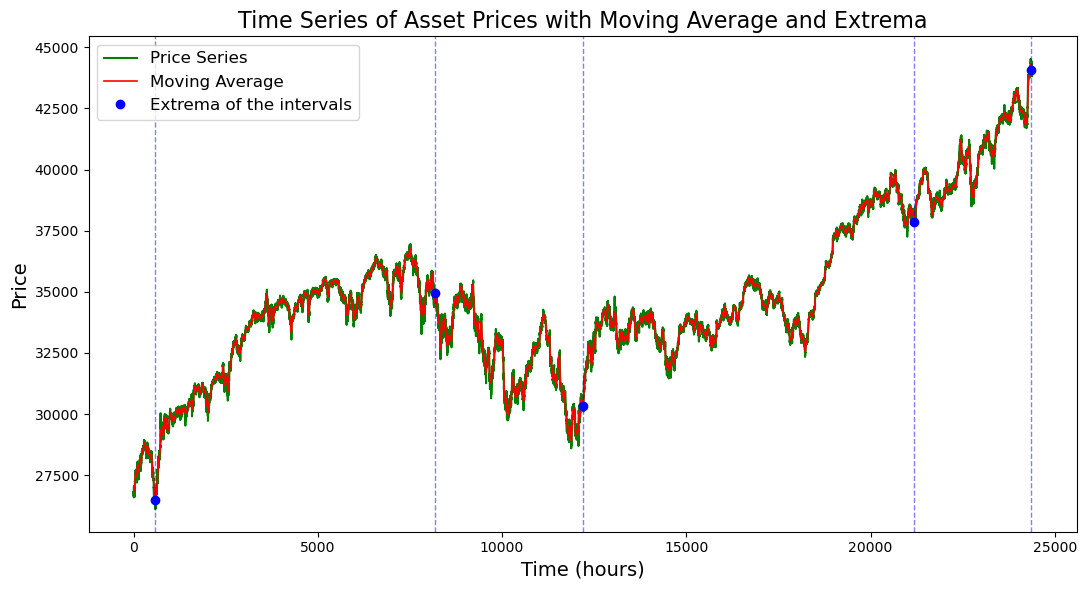

In [3]:
fig, ax = plt.subplots(figsize=(11, 6))
ax.plot(t, X, c="g", label="Price Series")
ax.plot(t[int(N/2):-int(N/2)+1], average, c="r", label="Moving Average", linewidth=1.2)
indices_int = np.floor(indices / 0.25).astype(int)
ax.plot(indices, average[indices_int], "ob", label="Extrema of the intervals")
for x in indices:
    ax.axvline(x=x, color='b', linestyle='--', alpha=0.5, linewidth=1)
ax.set_title("Time Series of Asset Prices with Moving Average and Extrema", fontsize=16)
ax.set_xlabel("Time (hours)", fontsize=14)
ax.set_ylabel("Price", fontsize=14)
ax.legend(loc="best", fontsize=12, frameon=True)
fig.tight_layout()
plt.show()

---

# Stochastic process approach

For datasets exhibiting weak mean reversion, we expect small amplitudes $A$ compared to the fluctuation (volatility $\sigma$) of the price. This is because the data tends to fluctuate more freely, with less of a tendency to return to the mean.  Essentially, the fluctuations themselves dominate the signal and we have a random walks. In contrast, asset price with strong mean reversion exhibit larger amplitudes compared to the volatility.

We begin by smoothing and rectifying the price using a filter. This filtering process aims to reduce the influence of high-frequency noise and reveal the underlying patterns. The goal is to obtain a smooth function that oscillates around the mean that we have centered at zero. We then determine the oscillation period $T$ by averaging the intervals between consecutive x-axis crossings. Similar results are obtained using the Fourier transform.
The amplitude $A$ is measured using SciPy's peak-finding algorithm, leveraging the period information to effectively distinguish individual peaks.

[*********************100%***********************]  1 of 1 completed


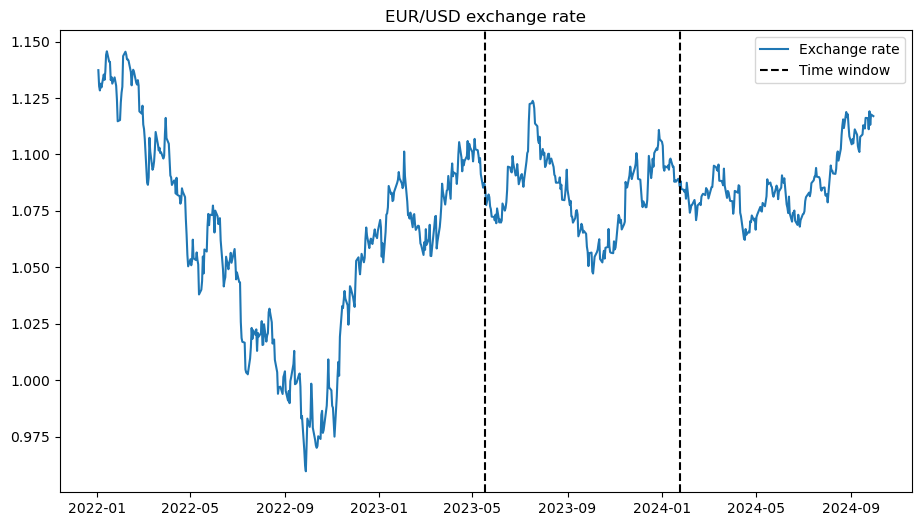

Time window considered: from 18-05-2023 to 24-01-2024


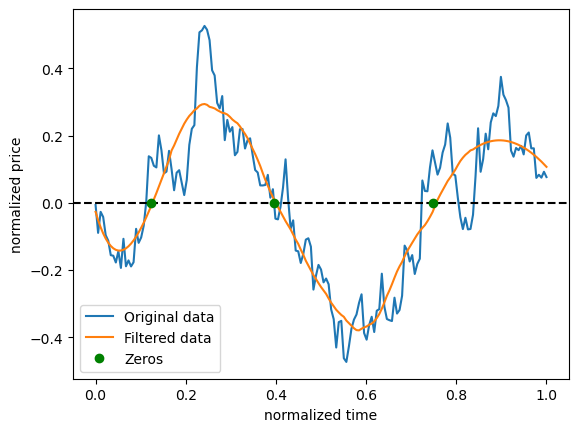

Period: 0.626 (112 days)
Period using Fourier: 0.500 (90 days)
Amplitude: 0.250


In [4]:
# Downloading data and subdividing it into chunks and removing the trend
# Daily datapoints from 2022-01-01 to 2024-10-01
data = mr.download_asset("EURUSD=X", start='2022-01-01',end='2024-10-01')
mesh = np.linspace(0, len(data), 5)
chunks = mr.removeTrend(data, mesh)
chunk_index = 2
plt.subplots(figsize=(11, 6))
plt.title("EUR/USD exchange rate")
plt.plot(data["AbsTime"], data["Close"], label='Exchange rate')
plt.axvline(data["AbsTime"].iloc[int(mesh[chunk_index])], color='k', linestyle='--', label='Time window')
plt.axvline(data["AbsTime"].iloc[int(mesh[chunk_index+1])], color='k', linestyle='--')
plt.legend()
plt.show()

print(f"Time window considered: from {data['AbsTime'].iloc[int(mesh[chunk_index])].strftime('%d-%m-%Y')} to \
{data['AbsTime'].iloc[int(mesh[chunk_index+1])].strftime('%d-%m-%Y')}")


# Extracting data from a specific chunk
x = chunks[chunk_index].to_numpy()
t = chunks[chunk_index].index.to_numpy()

# Normalization of price x and time t, smoothing the data
t = (t - t.min()) / (t.max()-t.min())
x = x / (x.max()-x.min())
x_filtered = savgol_filter(x, 60, 3)

# Detecting zeros, period and amplitude
zeros = mr.find_zeros(x_filtered) / len(t)
period = mr.find_period(x_filtered) / len(t)
amplitude = mr.find_amplitudes(x_filtered)

# Period using Fourier transform
priod_fft = mr.find_period_fft(x_filtered) / len(t)

plt.plot(t, x, label='Original data')
plt.plot(t, x_filtered, label='Filtered data')
plt.axhline(0, color='black', linestyle='--')
plt.plot(zeros, np.zeros_like(zeros), 'og', label='Zeros')
plt.xlabel('normalized time')
plt.ylabel('normalized price')
plt.legend()
plt.show()

print(f"Period: {period:.3f} ({period*len(t):.0f} days)")
print(f"Period using Fourier: {priod_fft:.3f} ({priod_fft*len(t):.0f} days)")
print(f"Amplitude: {amplitude:.3f}")

## Maximum likelihood estimation 
For the volatility $\sigma$ we assume the asset to behave as a stochastic process given by the general stochastic differential equation:
$$dx(t)=f(x,t,\boldsymbol{\theta})dt+g(x,t,\boldsymbol{\theta})dB(t)$$
where $f$ represents the deterministic term, $g$ the stochastic part, and $dB$ is a standard Brownian process with $\mathbb{E}[dB]=0$ and $\text{Var}[dB]=1$.  To capture the oscillatory behavior, we assume a sinusoidal trend around the mean, aiming for a drift term such that $\mathbb{E}[x(t)]=A\sin{\omega t+\varphi}$, .  Furthermore, we require both the mean and variance to be stationary, this motivates the use of an Ornstein-Uhlenbeck (OU) process. To find the parameters we use the maximum likelihood estimation and for the probability density function we approximate the propagator of the stochastic process using a normal distribution $p_{\boldsymbol{\theta}}(x,t|y)\simeq\mathcal{N}_y(x+f(x,t,\boldsymbol{\theta})t, tg^2(x,t,\boldsymbol{\theta}))$. From this we get the minimization problem:
$$\mathcal{L}(x,t,\boldsymbol{\theta})=\prod p_{\boldsymbol{\theta}}(x,t|y)$$
$$\boldsymbol{\theta}=\arg\max_{\boldsymbol{\theta}}\mathcal{L}(x,t,\boldsymbol{\theta})$$
However, direct maximization can be unstable. Therefore, we leverage the previously determined amplitude $A$ as exact values. Our model is the following:
$$f(x,t,\boldsymbol{\theta})=\theta(\mu(t)-x)\hspace{0.5cm}f(x,t,\boldsymbol{\theta})=\sigma$$
where $\sigma$ represents the price volatility. As mean reversion metric, we choose the ratio between volatility and amplitude: if the amplitude of the oscillation is bigger than the random fluctuation, then we have a mean reversion dynamic.

Optimal parameters:  [10.04122541 -1.55603493  0.181793    0.16056847]
Volatility: 0.1606
Volatility-Amplitude ratio: 0.6411


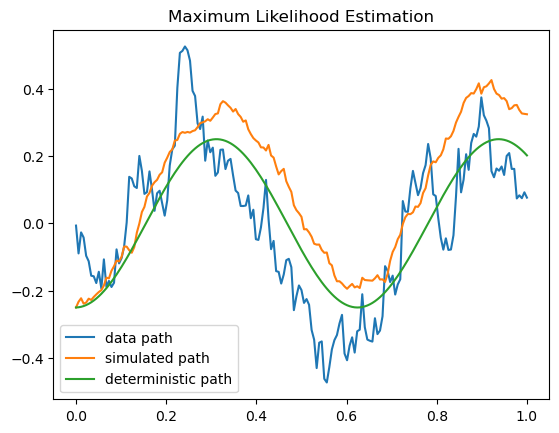

In [5]:
# Definition of the SDE
def f(t, x, params):
    omega, phi, theta, _ = params
    A = amplitude
    return theta * (A*np.sin(omega*t + phi) - x) + A*omega*np.cos(omega*t + phi)

def g(x, params):
    _, _, _, sigma = params
    return sigma

# Using previous results as initial guess
# to simplify the minimization process we assume that the amplitude is known from the previous calculation
frequency = 2*np.pi / period
guess = [frequency, -np.pi/2, 1.0, 1.0]

# Optimization
res = minimize(mr.log_likelihood, guess, args=(x_filtered, t, f, g), method='L-BFGS-B')
omega_val, phi_val, theta_val, sigma_val = res.get('x')

print("Optimal parameters: ", res.get('x'))
print(f"Volatility: {sigma_val:.4}")
print(f"Volatility-Amplitude ratio: {sigma_val/amplitude:.4}")

# We check if the results are consistent with the data by simulating the SDE
mu = lambda t, x : theta_val * (amplitude*np.sin(omega_val*t + phi_val) - x) + amplitude*omega_val*np.cos(omega_val*t + phi_val)
sigma = lambda t, x : sigma_val
np.random.seed(10)
X = mr.SDE_solver(x0=amplitude*np.sin(phi_val), t0=0.0, T=1.0, dt=(t[1]-t[0]), mu=mu, sigma=sigma)

plt.plot(t, x, label='data path')
plt.plot(t, X, label='simulated path')
plt.plot(t, amplitude*np.sin(t*omega_val+phi_val), label='deterministic path')
plt.title('Maximum Likelihood Estimation')
plt.legend()
plt.show()

## Autoregressive model

Given the poor volatility result from the maximum likelihood estimation, we turn to autoregressive (AR) models, a widely used technique for time series analysis.  Specifically, we utilize the AR(1) model, which, while maintaining the Markov property, can be viewed as the discrete-time analog of the Ornstein-Uhlenbeck stochastic differential equation used previously. The AR(1) model offers interpretability of its parameters, which is a key advantage.

An autoregressive model $AR(1)$ can be expressed as the discrete-time process $X_{k+1}=c+\varphi X_k+\varepsilon_k$. From the integration of the time-continuous stochastic differential equation for an Ornstein Uhlenbeck process we can express the parameters of the $AR(1)$ starting from the discretization $X_k=x(k\Delta t)$:
$$x(t)=x(0)e^{-\theta t}+\mu(1-e^{-\theta t})+\sigma\int_0^t e^{-\theta (t-s)}dB_s$$
This yields the following relationships:
$$\varphi=e^{-\theta\Delta t}\hspace{0.5cm}c=\mu(1-e^{-\theta\Delta t})\hspace{0.5cm}\varepsilon_k\sim\mathcal{N}\left(0,\frac{1}{2\theta}\sigma^2(1-e^{-2\theta \Delta t})\right)$$
Using the $AR(1)$ model we find $\varphi$ and the variance $\sigma_\varepsilon$ of $\varepsilon_k$ and therefore we can estimate both $\theta$ and $\sigma$:
$$\theta=-\frac{\log{\varphi}}{\Delta t}\hspace{1cm}\sigma=\varepsilon_k\sqrt{\frac{2\log{\varphi}}{\Delta{t}(\varphi^2-1)}}$$


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  179
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 250.711
Date:                Tue, 18 Feb 2025   AIC                           -497.422
Time:                        21:45:40   BIC                           -491.058
Sample:                             0   HQIC                          -494.841
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9645      0.021     46.634      0.000       0.924       1.005
sigma2         0.0035      0.000     11.536      0.000       0.003       0.004
Ljung-Box (L1) (Q):                   0.07   Jarque-

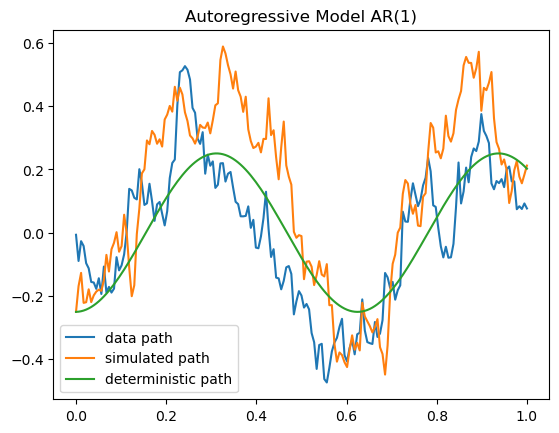

Volatility using AR(1) model: 0.8035
Volatility-Amplitude ratio: 3.208


In [8]:
# Using AR(1) model to estimate the volatility
AR_model = ARIMA(x, order=(1,0,0), trend='n', enforce_stationarity=False)
res = AR_model.fit(method='burg')
print(res.summary(),'\n')

# Extracting the parameters of the AR(1) model
AR_phi = res.params[0]
AR_sigma = res.params[1]

# Transform the AR(1) model parameters into SDE parameters
dt = t[1] - t[0]
theta = -np.log(AR_phi)/dt
volatility = np.sqrt(AR_sigma*(2*theta/(1-AR_phi**2)))

# We check if the results are consistent with the data by simulating the SDE
mu = lambda t, x : theta * (amplitude*np.sin(omega_val*t + phi_val) - x) + amplitude*omega_val*np.cos(omega_val*t + phi_val)
sigma = lambda t, x : volatility
np.random.seed(10)
X = mr.SDE_solver(x0=amplitude*np.sin(phi_val), t0=0.0, T=1.0, dt=(t[1]-t[0]), mu=mu, sigma=sigma)

plt.plot(t, x, label='data path')
plt.plot(t, X, label='simulated path')
plt.plot(t, amplitude*np.sin(t*omega_val+phi_val), label='deterministic path')
plt.title('Autoregressive Model AR(1)')
plt.legend()
plt.show()

print(f"Volatility using AR(1) model: {volatility:.4}")
print(f"Volatility-Amplitude ratio: {volatility/amplitude:.4}")

---

# Normality test approach

TODO

---

# Stochastic and normality approaches comparison

TODO

---
# Mean reversion trading strategy 
To comprehend the results we have obtained, we will proceed to create a buying/selling strategy based on a mean-reverting approach.  
The goal of this part of the project is to demonstrate the effectiveness of the parameters we have previously found by utilizing the Mean Reversion Index of the dataset as a parameter in a buying/selling strategy. As a result, we expect to achieve better profits by utilizing the information previously obtained.  

To implement a trading strategy of this kind, we will create an algorithm that assumes the asset's price is oscillating in a mean-reverting manner. Therefore, it will buy when the price is low and hold the asset until it reaches a new high. We will use the mean reversion indexes we found earlier to buy and sell more in the parts of the dataset that exhibit a stronger mean-reverting behavior.

### Identifying Buy and Sell Points

The first step to apply this trading strategy consists of identifying the points where to buy and sell. We do this by calculating the ratio between the current price of the asset and the moving average, which is done by applying the function `mr.rectify_price`. From this result is possible to identify the rolling percentiles of the dataset.  
This calculation is related to the financial concept of **Bollinger Bands**. These bands indicate the extremes after which it is desirable to buy or sell the stock. Essentially, these bands determine how much the price needs to oscillate from its mean value to trigger a buying or selling signal.

In [37]:
# Load asset data
df = mr.load_asset("data/DJ_M15_202009240845_202411131015.csv")
df = df.set_index(pd.DatetimeIndex(df['AbsTime'].values))
df = df[::50] # Reduce the size of the dataset
df.drop(['AbsTime'], inplace = True, axis = 1)

# Compute moving averages, returns, and ratios
window = 100
df['MA'] = df['Close'].rolling(window=100).mean()
df['Simple_Returns'] = df.pct_change(1)['Close']
df['Log_Returns'] = np.log(1+df['Simple_Returns'])
df['Ratios'] = mr.rectifiy_price(df, "Close", window=window)

# Compute rolling percentiles of the ratios
percentiles = [15, 50, 85]
for p in percentiles:
	df[f'perc_{p}'] =df["Ratios"].rolling(window=len(df)//10).quantile(p/100)

To find a good balance between safety and effectiveness in the program, we decided to sell only when the oscillations are significantly high, this corresponds to a price movement that goes below the 15% percentile or above the 85% percentile. In the following, we visualize the **Bollinger Bands**.

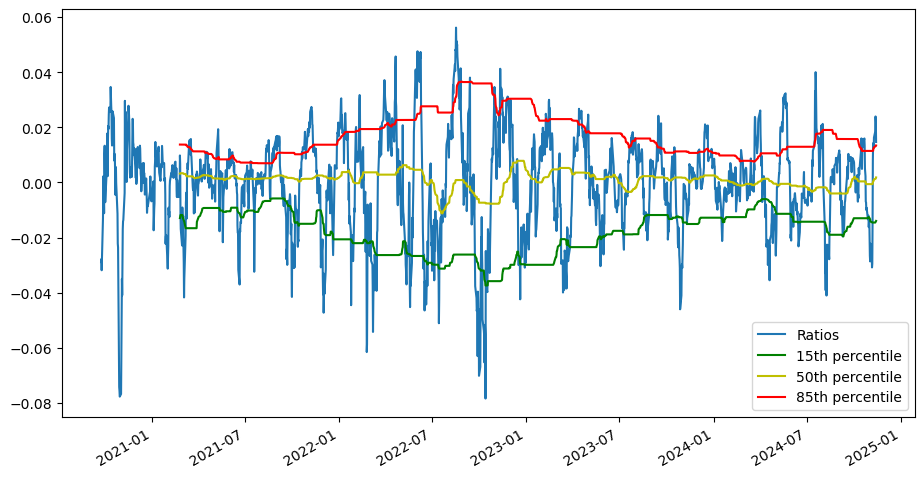

In [38]:
plt.figure(figsize=(11,6))
df['Ratios'].dropna().plot(legend = True)
plt.plot(df['perc_15'], c='g', label = '15th percentile')
plt.plot(df['perc_50'], c='y', label = '50th percentile')
plt.plot(df['perc_85'], c='r', label = '85th percentile')
plt.legend()
plt.show()

Once we have individuate the ticks at which buy/sell we proceed to formulating the trading part of the algorithm. Firstly we define the Mean Reverting Index we are going to use. Note that from the previus results this index will have values that change over time but we are inderested in comparing the results obtained with the case of a pure strategy that doesn't comprehend a previous mean reverting analysis, therfore we put the value of the Index to 1.

Secondly we proceed to formulate the buy/sell ticks that will be used to spot the points at which buy/sell.

In [61]:
df['MRI'] = 1.0

# Buy and sell signals: buy (+1) when the ratio is below the 15th percentile, sell (-1) when it is above the 85th percentile
df['Positions'] = np.where(df.Ratios > df['perc_85'], -1, 0)
df['Positions'] = np.where(df.Ratios < df['perc_15'], 1, df['Positions'])
df['Positions'] = df['Positions'].ffill()

# Compute current and previous buy and sell prices
df['Buy'] = np.where(df['Positions'] == 1 , df['Close'], np.nan)
df['Sell'] = np.where(df['Positions'] == -1 , df['Close'], np.nan)
df['Previous_Buy'] = df['Buy'].shift(1)
df['Previous_Sell'] = df['Sell'].shift(1)

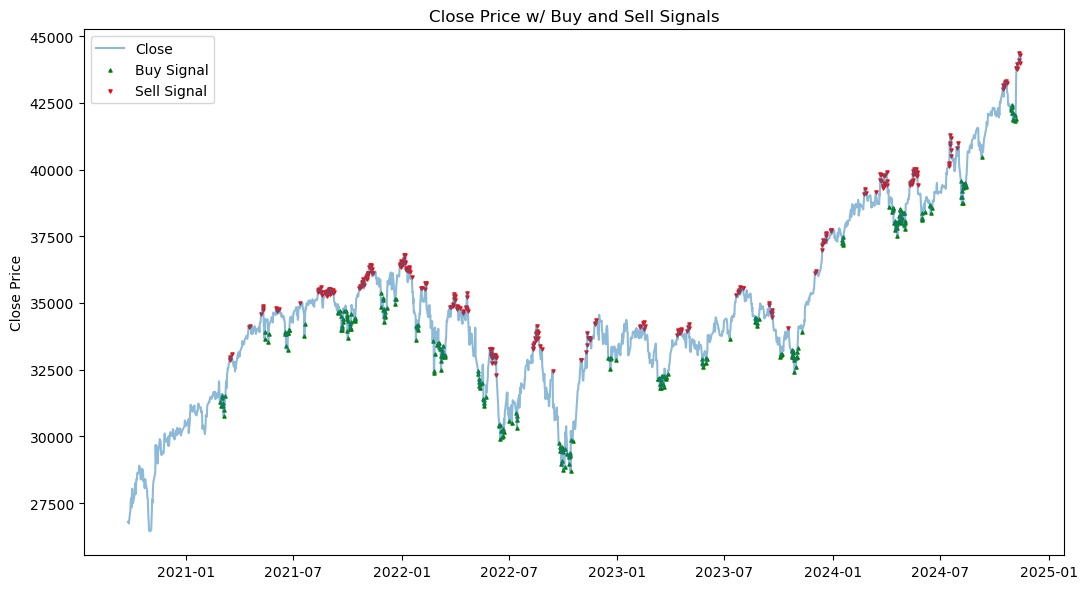

In [62]:
# visualization of all the buy/sell signals just found
fig, axes = plt.subplots(1, 1, figsize=(11, 6))
axes.set_title('Close Price w/ Buy and Sell Signals')
axes.plot(df['Close'], alpha=0.5, label='Close')
axes.scatter(df.index, df['Buy'], c='g', label='Buy Signal', marker='^', s=5)
axes.scatter(df.index, df['Sell'], c='r', label='Sell Signal', marker='v', s=5)
axes.set_ylabel('Close Price')
axes.legend()
plt.tight_layout()
plt.show()

### Trading strategy Function

We now proceed to define the actual function that trades according to the signals we have determined. In particular, the program will buy or sell a fraction of the asset at the defined price whenever a signal occurs. To contain the investment, which would otherwise be very high considering the number of buy signals, we have coded the program to buy a fixed fraction of the asset, corresponding to approximately one euro per investment.  

We observe that the profit growth rate is closely linked to the price behavior. Specifically, we experience significant losses in the part of the asset that exhibits clear trending behavior and substantial profits when the asset follows a more sinusoidal pattern.

Total Buy Signals: 276
Total Sell Signals: 282
Total Euro Invested: 272.4816979686582
Total percentual profit: 8.46%


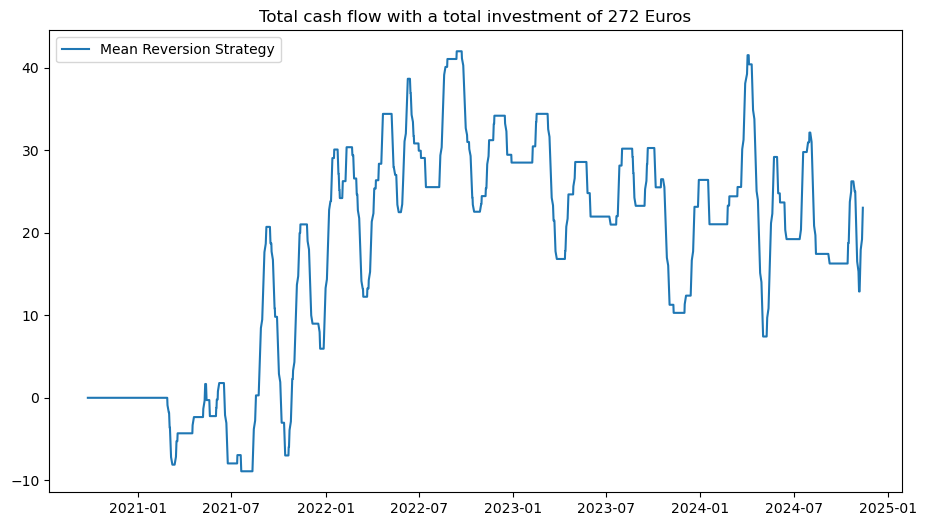

In [64]:
def apply_trading_strategy(df):
    mv = df['Close'].mean()
    #Compute weighted strategy
    df['Investment'] = np.where(df['Buy'].notna(), df['Buy'] / mv * df['MRI'], 0)
    df['Revenue'] = np.where(df['Sell'].notna(), df['Sell'] / mv * df['MRI'], 0)
    df['Trade_Profit'] = df['Revenue'] - df['Investment']
    df['Cum_Profit'] = df['Trade_Profit'].cumsum()

    #Count buy/sell signals
    num_buys = df['Buy'].count()
    num_sells = df['Sell'].count()
    print(f"Total Buy Signals: {num_buys}")
    print(f"Total Sell Signals: {num_sells}")

    #Calculate total investment
    df['Investment_Per_Buy'] = df['Buy'] / mv
    total_investment = df['Investment_Per_Buy'].sum()
    print(f"Total Euro Invested: {total_investment}")

    #Compute and print total percentual profit
    total_profit_percent = df['Cum_Profit'].iloc[-1] / total_investment * 100
    print(f"Total percentual profit: {total_profit_percent:.2f}%")

    #Plot results
    plt.figure(figsize=(11,6))
    plt.title(f'Total cash flow with a total investment of {int(total_investment)} Euros')
    plt.plot(df['Cum_Profit'].dropna(), label='Mean Reversion Strategy')
    plt.legend()
    plt.show()

    return None

# Apply trading strategy
df["MRI"] = 1.0
apply_trading_strategy(df)

## Weighted Mean Revesion trading strategy
We now proceed to apply the results obtained from the previous sections. As hinted this is done by substituing the Mean Reversion Index we found for each method, before calling the trading function.

### Normality test approach

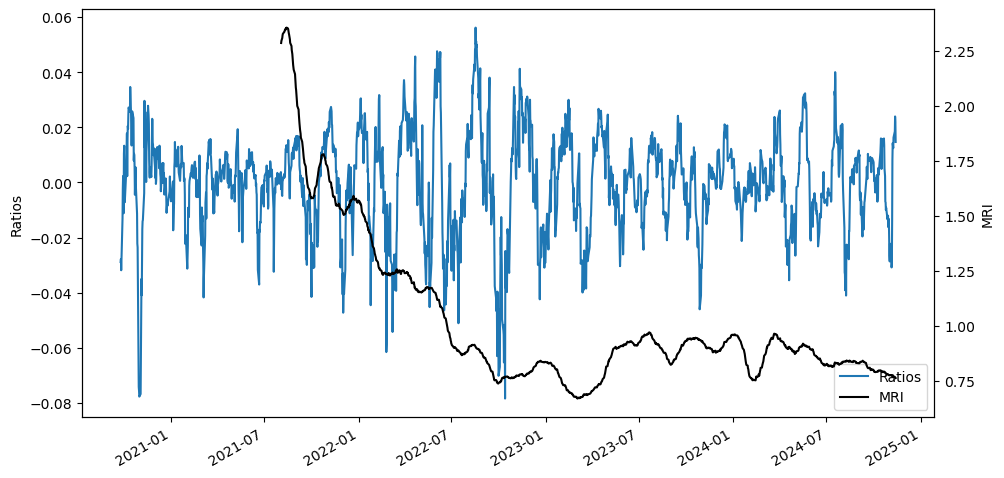

Total Buy Signals: 276
Total Sell Signals: 282
Total Euro Invested: 272.4816979686582
Total percentual profit: 28.52%


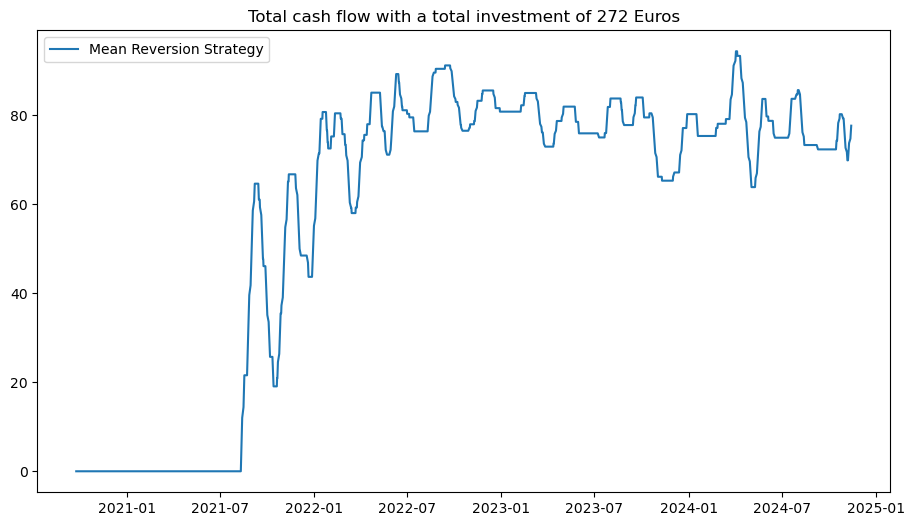

In [75]:
df["MRI"] = df["Ratios"].rolling(window = 400, center = False).apply(mr.assess_normality_rolling, raw=True, args = (int(30),) )*2 + 0.5
df['MRI'] = mr.savgol(df['MRI'], window_length=100, polyorder=3)

ax = df["Ratios"].plot(figsize=(11,6), label="Ratios")
ax2 = ax.twinx()
df["MRI"].plot(ax=ax2, color='k', label="MRI")
ax.set_ylabel("Ratios")
ax2.set_ylabel("MRI")
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, loc='lower right')
ax.set_xlabel("")
ax.set_ylabel("Ratios")
ax2.set_ylabel("MRI")
plt.show()

apply_trading_strategy(df)

### Stochastic process approach

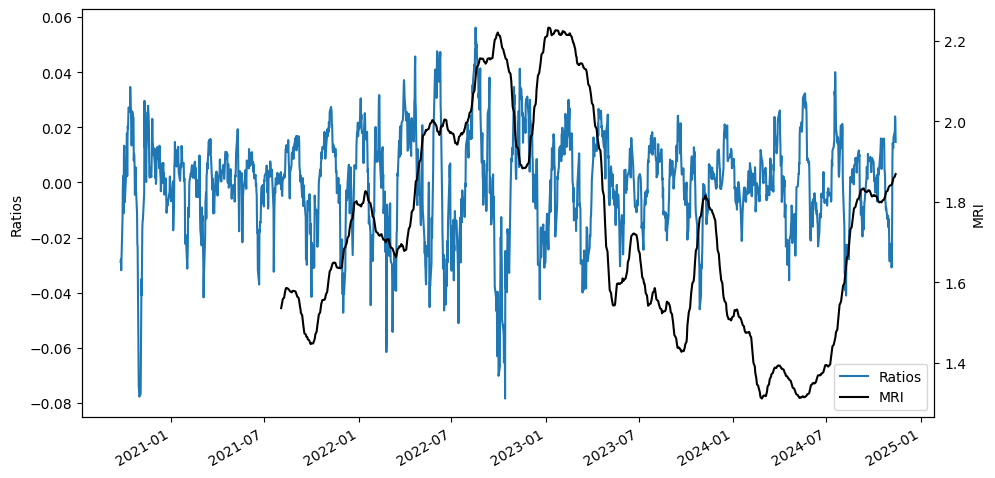

Total Buy Signals: 276
Total Sell Signals: 282
Total Euro Invested: 272.4816979686582
Total percentual profit: 16.81%


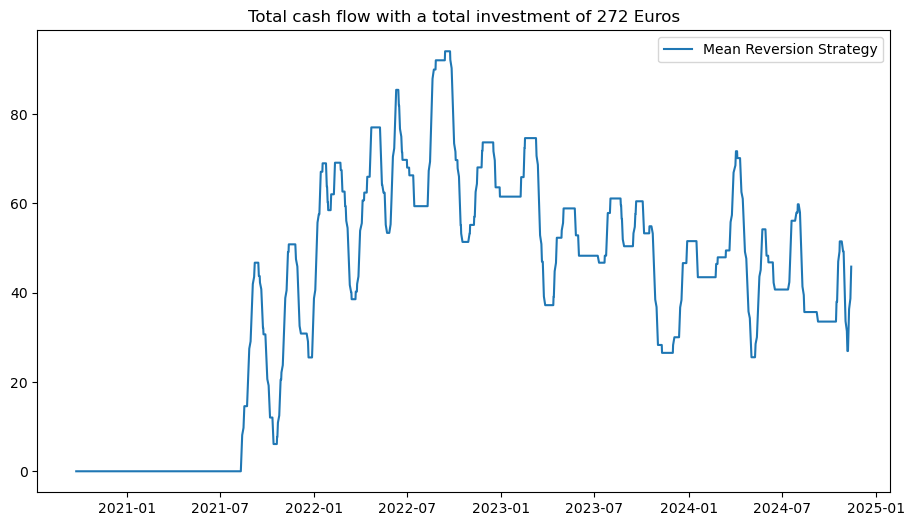

In [74]:
# To prompt the mean reversion strategy, we change normalization of the MRI
# increasing the number of stocks to buy/sell if the MRI is close 1
df['MRI'] = (df["Ratios"].rolling(window=400, center=False).apply(mr.mean_revertion_index, raw=True))*2 + 1.0
df['MRI'] = mr.savgol(df['MRI'], window_length=100, polyorder=3)

ax = df["Ratios"].plot(figsize=(11,6), label="Ratios")
ax2 = ax.twinx()
df["MRI"].plot(ax=ax2, color='k', label="MRI")
ax.set_ylabel("Ratios")
ax2.set_ylabel("MRI")
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, loc='lower right')
ax.set_xlabel("")
ax.set_ylabel("Ratios")
ax2.set_ylabel("MRI")
plt.show()

apply_trading_strategy(df)